# Learning to play Blackjack with Monte Carlo methods

https://en.wikipedia.org/wiki/Blackjack

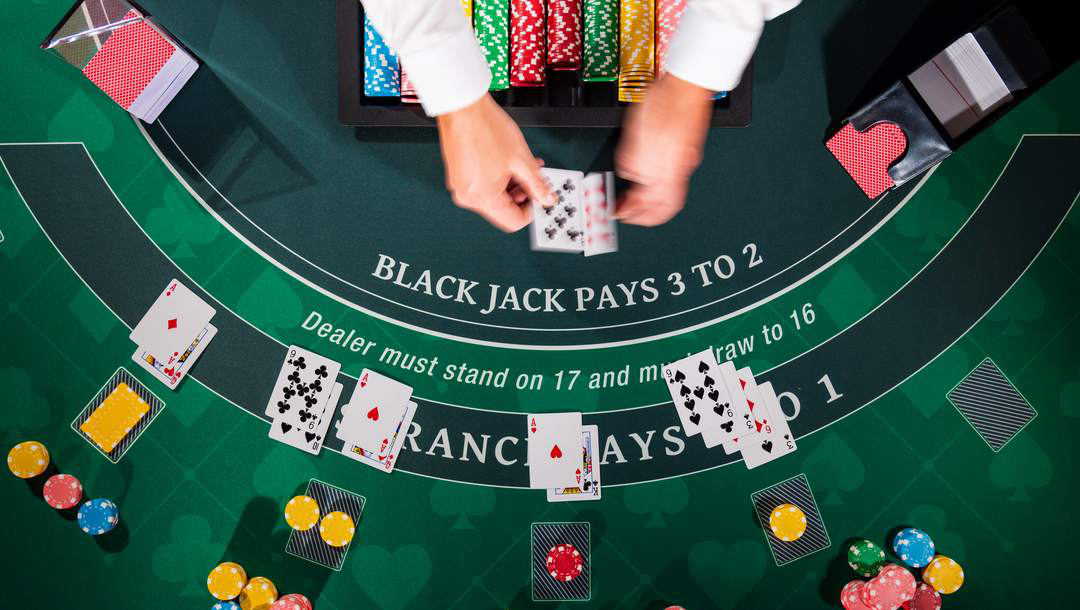

## Setting up the environment

We'll be using a library called `gymnasium` that has many simpler interfaces for interacting with environments used to test Reinforcement Learning algorithms: 
https://gymnasium.farama.org/environments/toy_text/blackjack/

In [1]:
!python --version

Python 3.9.5


In [2]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from typing import Tuple, Sequence, Callable, Mapping, Union
import copy
import pickle
from tqdm import tqdm 
import matplotlib.pyplot as plt

# helper visualization methods 
import blackjack_plots

In [3]:
np.random.seed(2)

In [4]:
env = gym.make('Blackjack-v1', sab = True) # create blackjack environment

In [5]:
env.action_space # number of actions available (0 "stay" or 1 "hit")

Discrete(2)

In [6]:
env.observation_space # the state space is comprised of (total_player, visible_card_dealer, Whether or not I have an Ace)
                      # total player is in the range [4 - 32]
                      # visible_card_dealer in range [Ace, 2, 3, .., 10]
                      # Whether or not I have a usable ace: True/False

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [7]:
PlayerTotal = int
DealerCard = int
UsableAce = bool

State = Tuple[PlayerTotal, DealerCard, UsableAce]

## Example Interacting with the env 

Reset the environment and get the first state (player sum, dealer card showing, Usable Ace?)

In [8]:
env.reset() #reset the environment, get the first state

((18, 5, False), {})

Take an action, e.g. hit = 1 and see the resulting next state

In [9]:
action = 1 # hit
env.step(action) # returns ((current state), reward, termination, truncation, info) 

((28, 5, False), -1.0, True, False, {})

# Define a policy $\pi$

- $\pi$ maps states to actions S -> A. 


- Here state is a tuple: $(PlayerScore, DealerCardShowing, UsableAce)$ and our actions are $\{0,1\}$

- Assign to each possible state a probablity distribution over actions (either 0 or 1) 

$$
P(Action = 0|PlayerScore, DealerScore, AceShowing)
$$
and 
$$
P(Action = 1|PlayerScore, DealerScore, AceShowing)
$$


In [10]:
ActionProb = np.ndarray[float, float]

In [11]:
def random_policy(player_state: State) -> ActionProb:
    ''' sampling an action at random '''
    return np.array([0.5, 0.5])


Visualize the policy

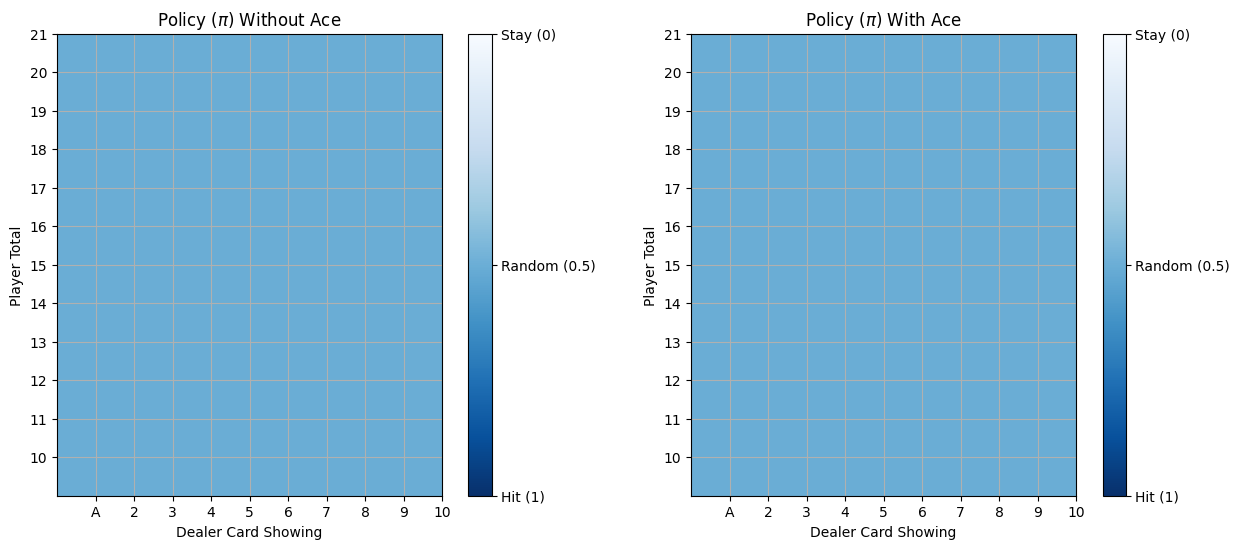

In [12]:
# random policy, so for every state we have probability 0.5
blackjack_plots.plot_policy(random_policy)

In [13]:
def naive_policy(player_state: State) -> ActionProb:
    ''' an implementation of a niave policy '''
    
    player_total, deal_card_showing, ace = player_state
 
    # if I have 20 or 21 "stay"
    if player_total >= 20:
        return np.array([1, 0]) 
    
    # otherwise "hit"
    else:
        return np.array([0, 1])
        

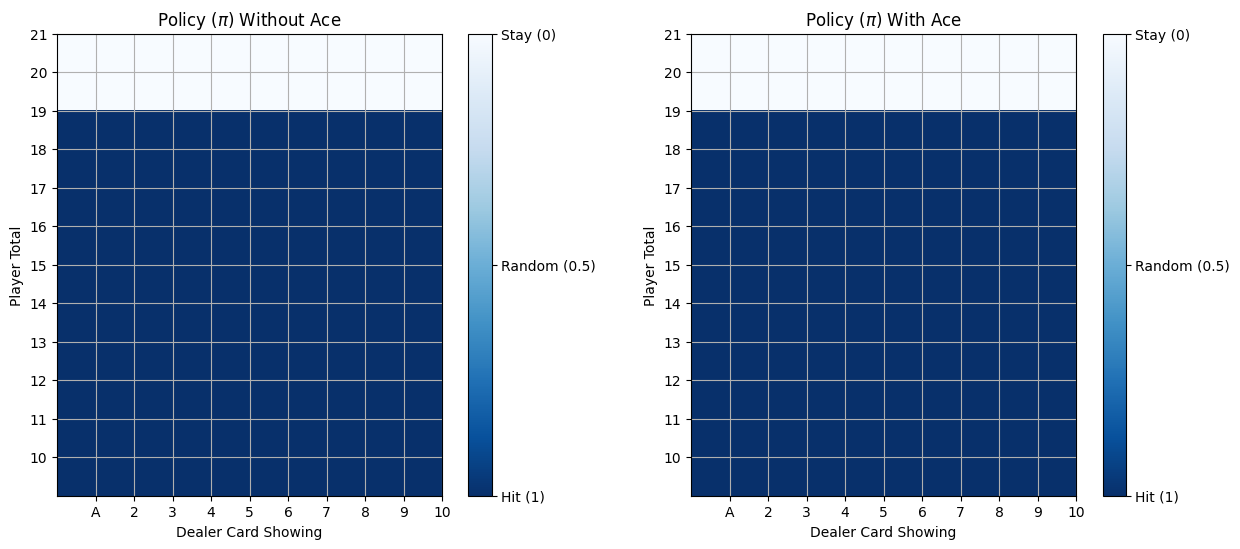

In [14]:
blackjack_plots.plot_policy(naive_policy)

In [15]:
''' Create your own policy and see how good it performs! '''
def my_policy(player_state: State) -> ActionProb:
              
    player_total, deal_card_showing, ace = player_state
              
    if deal_card_showing > 7 and deal_card_showing < 10:
        return np.array([0, 1])
    
    elif player_total > 14 and player_total < 22:
        return np.array([0.3, 0.7])
    
    return np.array([0.5,0.5])

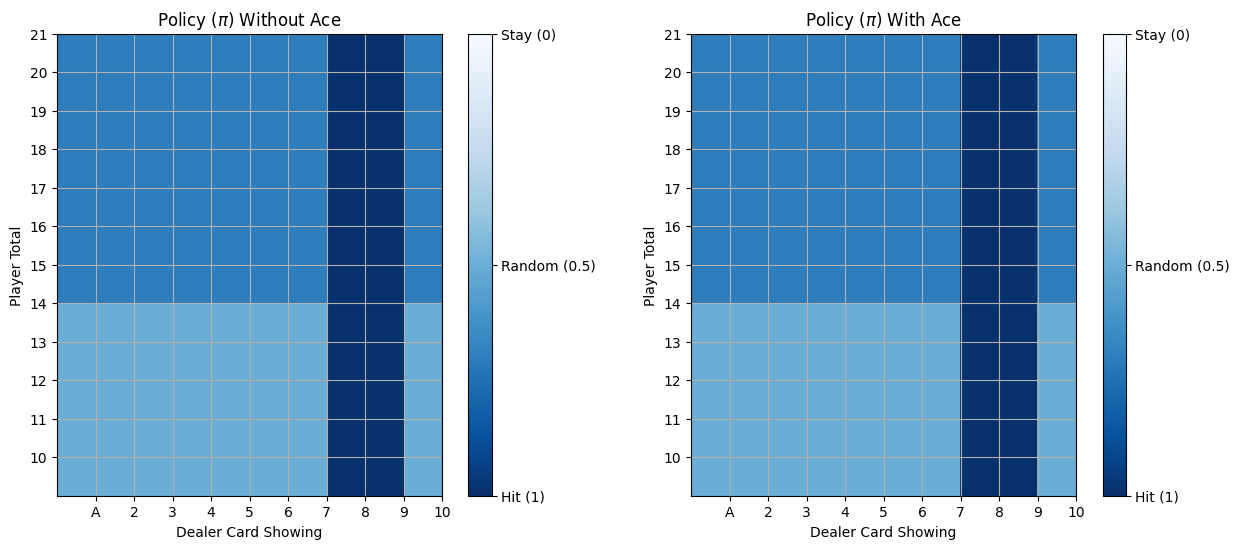

In [16]:
blackjack_plots.plot_policy(my_policy)

# Example of running a policy in the environment

In [17]:
state = env.reset()[0]
actions = [0, 1]
print(f"**Start of Game with state: {state} \n")

game_over = False
while not game_over:
    
    player_total, dealer_card, usable_ace = state
    
    # take an action with random probability
    action = np.random.choice(actions, 1, p = random_policy(state))[0]
    print(f"Taking action: {'Stay' if not action else 'Hit'}")
    
    # transition
    state, reward, game_over, _, _ = env.step(action)
    print(f"Transitioning to state: {(state)} with reward: {reward}")

**Start of Game with state: (21, 1, True) 

Taking action: Stay
Transitioning to state: (21, 1, True) with reward: 0.0


In [18]:
Action = int
Reward = int

Episode = list[State, Action, Reward]

In [19]:
def generate_episode(policy:Mapping[State, ActionProb]) -> Episode:
    '''
    Function to generate an episode following a policy (as a dictionary)
    '''
    
    episode = [] # store the episode
    state = env.reset()[0] # start the game
    
    game_over = False
    while not game_over:
        
        # get action
        action = np.random.choice(actions, 1, p = policy[state])[0]

        # take action in environement
        next_state, reward, game_over, _, _ = env.step(action)

        # append outcome
        episode.append((state, action, reward))
        
        state = next_state
    
    return episode

In [20]:
def generate_episode(policy:Union[Callable, Mapping[State, ActionProb]]) -> Episode:
    '''
    Function to generate an episode following a policy
    '''
    
    episode = [] # store the episode
    state = env.reset()[0] # start the game
    
    game_over = False
    while not game_over:
        
        # get action
        action_prob = policy[state] if isinstance(policy, dict) else policy(state)
        action = np.random.choice(actions, 1, p = action_prob)[0]

        # take action in environement
        next_state, reward, game_over, _, _ = env.step(action)

        # append outcome
        episode.append((state, action, reward))
        
        state = next_state
    
    return episode

In [21]:
def generate_episodes(policy:Union[Callable, Mapping[State, ActionProb]], num_episodes: int) -> list[Episode]:
    '''Generate multiple episodes'''
    
    episodes = []

    for _ in range(num_episodes):
        episodes.append(generate_episode(policy))
        
    return episodes

In [22]:
# example of generating a random episode
generate_episode(random_policy)

[((6, 9, False), 0, 1.0)]

In [23]:
# example of generating an episode following a naive policy
generate_episode(naive_policy)

[((14, 10, False), 1, -1.0)]

In [24]:
# generate multiple episodes
episodes = generate_episodes(naive_policy, 1_000)

In [25]:
episodes[:10]

[[((13, 2, False), 1, 0.0),
  ((19, 2, False), 1, 0.0),
  ((20, 2, False), 0, 1.0)],
 [((17, 2, False), 1, -1.0)],
 [((16, 10, False), 1, -1.0)],
 [((12, 7, False), 1, 0.0),
  ((15, 7, False), 1, 0.0),
  ((20, 7, False), 0, 1.0)],
 [((7, 2, False), 1, 0.0),
  ((15, 2, False), 1, 0.0),
  ((19, 2, False), 1, -1.0)],
 [((13, 6, False), 1, 0.0), ((18, 6, False), 1, -1.0)],
 [((11, 10, False), 1, 0.0),
  ((14, 10, False), 1, 0.0),
  ((18, 10, False), 1, -1.0)],
 [((17, 10, False), 1, 0.0), ((19, 10, False), 1, -1.0)],
 [((19, 4, False), 1, -1.0)],
 [((18, 10, False), 1, -1.0)]]

# Evaluating a policy

Now that we know what a policy *is*, we would like to know *how well* we would perform if we follow it. We can quantify this idea as the expected sum of rewards we would get from following this policy. In reinforcement learning, this is called the **Value Function** (denoted $V_{\pi}$).

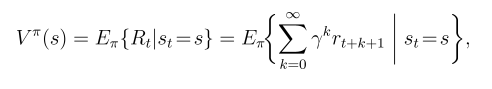

An associated quantity very similar to the value function is called the **action-value function** (denoted $Q_{\pi}$). The only difference is in conditioning on the first action taken before evaluating the expected reward we would get thereafter.

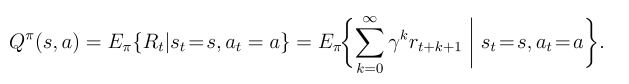

There are several ways of actually computing these quantities, here we will focus on a Monte Carlo approach.

## Monte Carlo Estimation

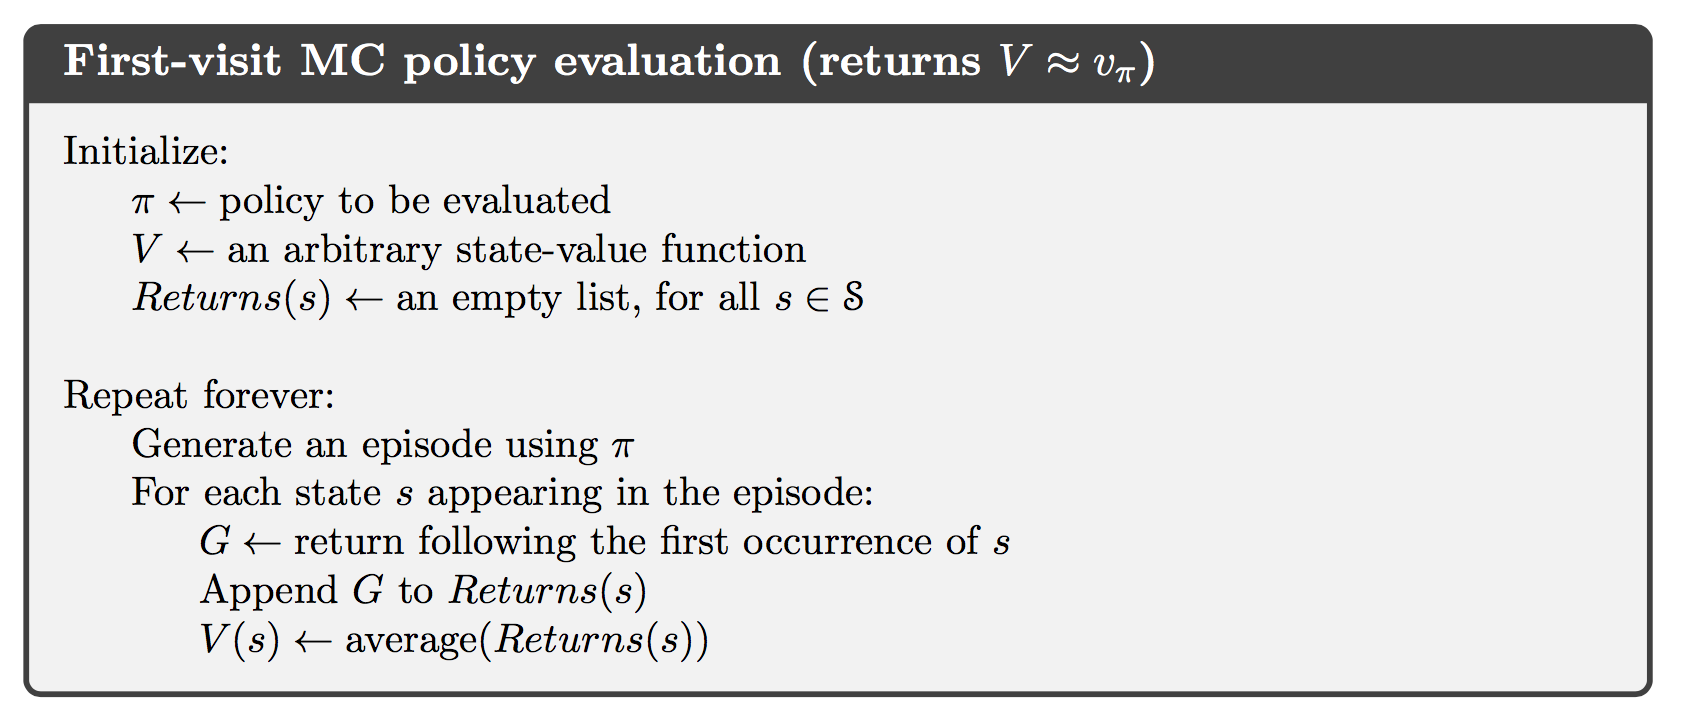

In [26]:
def get_return(episode, indx = 0, discount = 1.0):
    '''
    Function to get the discounted return of an episode
    '''
    if indx > len(episode):
        raise ValueError
    
    total = 0
    
    for i in range(indx, len(episode)):
        state, action, reward = episode[i]
        
        total += (discount ** i) * reward

    return total

In [27]:
def mc_estimation(episodes, discount = 1.0):
    '''
    Implementation of first visit Monte Carlo estimation 
    '''
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in episodes:
        
        states_visited_during_episode = set()
        index = 0
        
        for index, step in enumerate(episode):
            
            state, action, reward = step
            
            if (state not in states_visited_during_episode):
                
                states_visited_during_episode.add(state)
                
                r = get_return(episode, index, discount = discount)
                returns_sum[state][action] += r
                N[state][action] += 1.0
                Q[state][action] = returns_sum[state][action] / N[state][action]
                
            index += 1
            
    return Q

In [28]:
naive_episodes = generate_episodes(naive_policy, 100_000)
rand_episodes = generate_episodes(random_policy, 100_000)

In [29]:
naive_Q = mc_estimation(naive_episodes)
rand_Q = mc_estimation(rand_episodes)

In [30]:
def Q_to_V(Q:dict, policy: Callable) -> dict:
    '''
    Function to change Q values into V values
    '''
    v={}
    for state, value in Q.items():
        v[state] = np.dot(policy(state), value)
    
    return v

In [31]:
naive_v = Q_to_V(naive_Q, naive_policy)
rand_v = Q_to_V(rand_Q, random_policy)

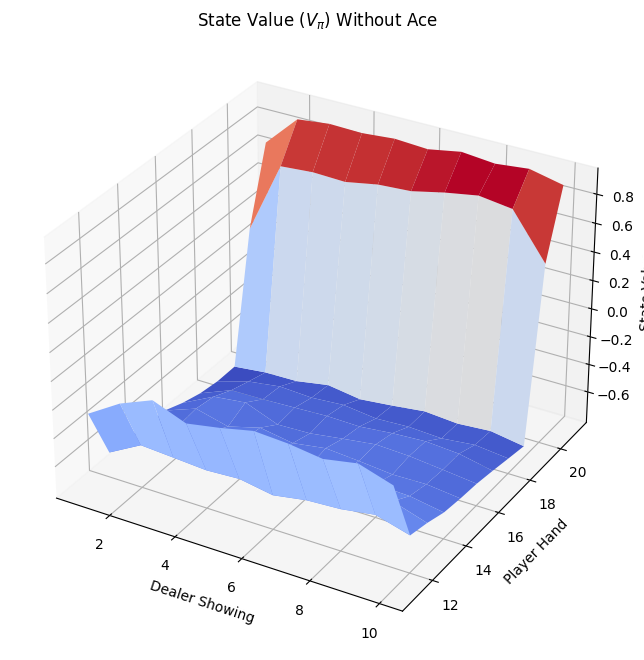

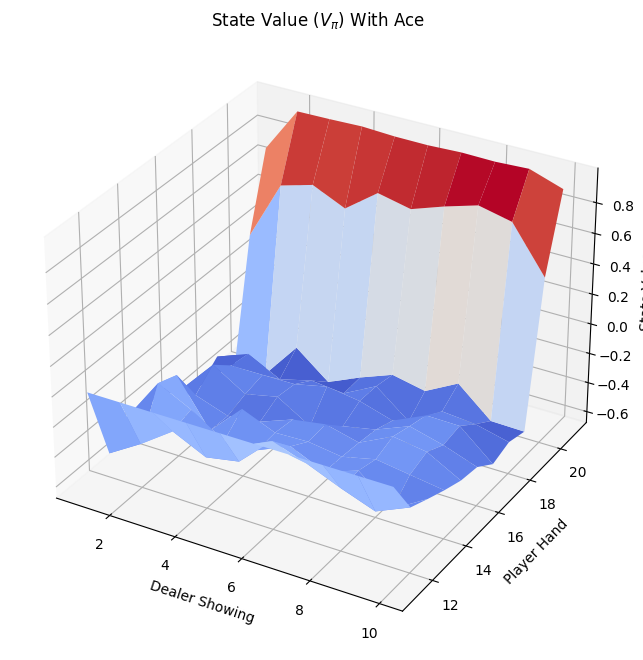

In [32]:
blackjack_plots.plot_values(naive_v)

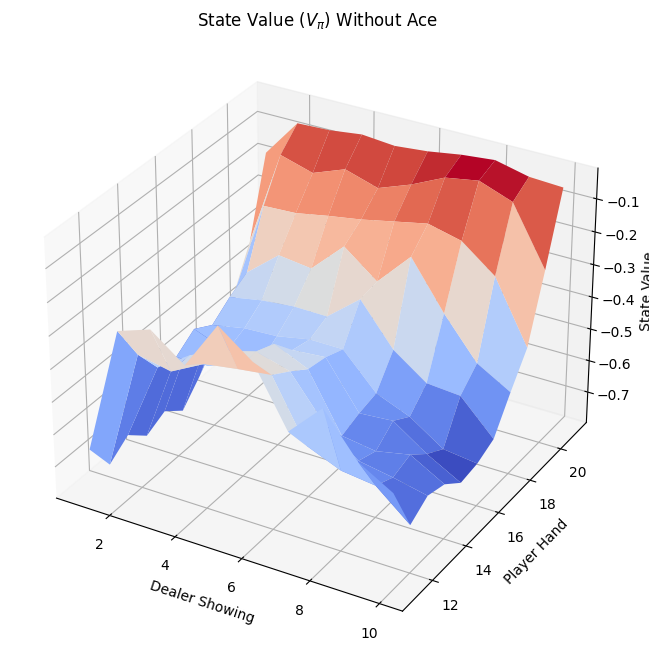

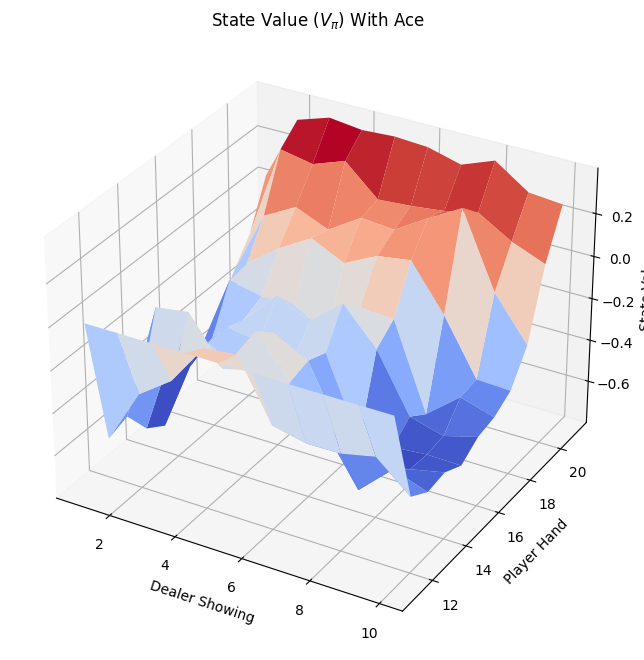

In [34]:
blackjack_plots.plot_values(rand_v)

# Monte Carlo Control

Now that we know how to evaluate a policy, the next question is how to make it better (This is referred to as the control problem). It turns out we can just we just be greedy with respect to the action that would give us the largest $Q$ value.

This leads us to the following MC control algorithm:

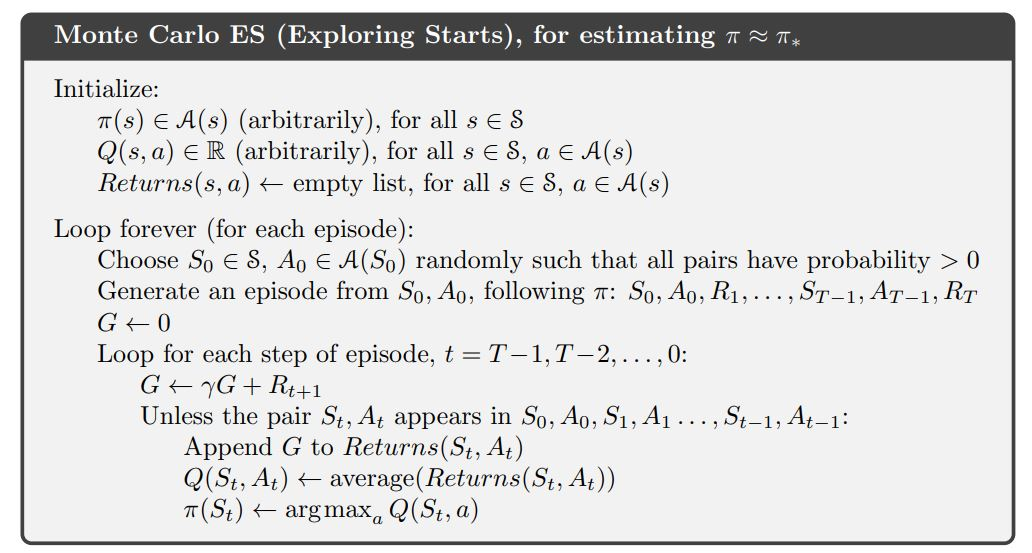

In [35]:
num_episodes = 500_000

In [36]:
final_epsilon = 0.1
start_epsilon = 1.0
epsilon_decay = start_epsilon / (num_episodes / 2)

In [37]:
def update_epsilon(epsilon):
    return max(final_epsilon, epsilon - epsilon_decay)

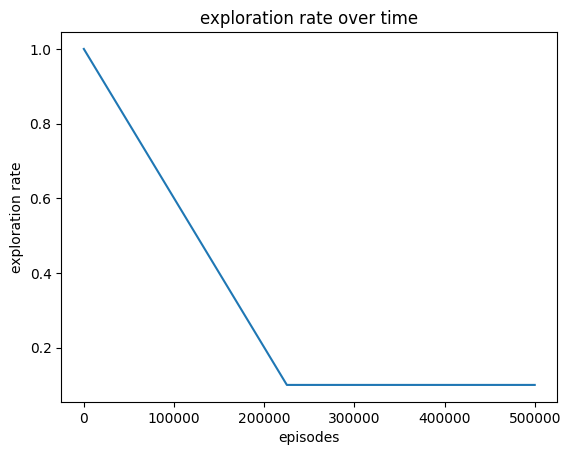

In [38]:
# Visualizing this decay
import matplotlib.pyplot as plt

t = np.arange(0, num_episodes)
y = [start_epsilon]
for i in t[:-1]:
    y.append(update_epsilon(y[-1]))


plt.plot(t, y)
plt.xlabel("episodes")
plt.ylabel("exploration rate")
plt.title("exploration rate over time")
plt.show()

In [39]:
class MonteCarloBlackjackAgent:
    def __init__(
        self,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 1,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.N = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(lambda: np.zeros(env.action_space.n))
        
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        

    def get_action(self, state: State) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.Q[state]))

    def update(
        self,
        episode: list[State, Action, Reward],
    ):
        visited_states = set()
        for index, step in enumerate(episode):
            state, action, reward = step
            
            
            visited_states.add(state)
            self.returns[state][action] += get_return(episode, index, discount = mc_agent.discount_factor)
            self.N[state][action] += 1
            self.Q[state][action] = self.returns[state][action] / self.N[state][action]
            

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [40]:
mc_agent = MonteCarloBlackjackAgent(
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [41]:
env = gym.make('Blackjack-v1', sab = True) # create blackjack environment
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)

for episode_num in tqdm(range(num_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    episode = []
    while not done:
        # action = agent.get_action(obs)
        action = mc_agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        episode.append((obs, action, reward))
        
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        
    # update the agent
    mc_agent.update(episode)
    mc_agent.decay_epsilon()

100%|███████████████████████████████████████████| 500000/500000 [02:55<00:00, 2853.67it/s]


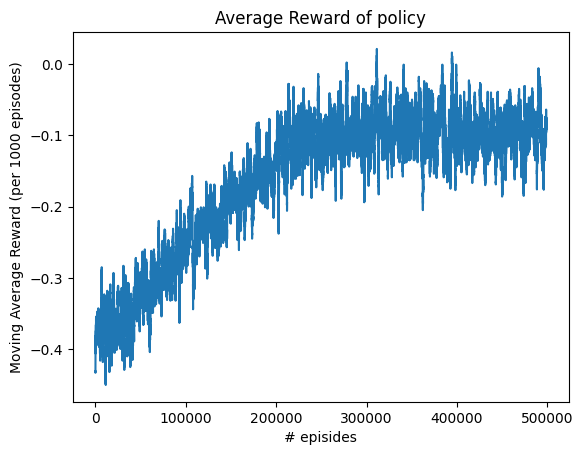

In [42]:
moving_avg_length = 1000

plt.plot(np.convolve(np.array(env.return_queue).flatten(), np.ones(moving_avg_length), mode = 'valid') / moving_avg_length)
plt.xlabel('# episides')
plt.ylabel(f'Moving Average Reward (per {moving_avg_length} episodes)')
plt.title("Average Reward of policy")
plt.show()

In [43]:
# turn dict policy to array

In [44]:
policy_arr = np.ones((32, 11, 2, 2))
for state in mc_agent.Q:
    player_score, dealer_card, ace = state
    action = np.argmax(mc_agent.Q[state])
    action_hit = action
    action_stay = 1 - action
    policy_arr[player_score, dealer_card, int(ace)] = [action_stay, action_hit]

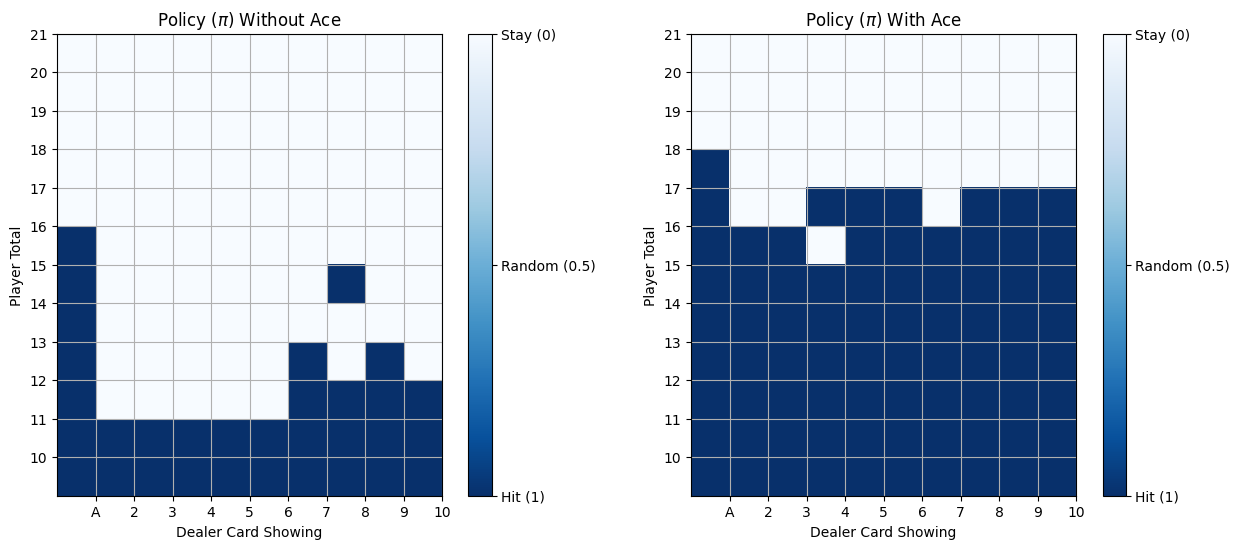

In [45]:
blackjack_plots.plot_policy(policy_arr)

In [67]:
# plot

In [68]:
# def mc_control(num_episodes, explore_rate, discount = 1.0):
    
#     Q = defaultdict(lambda: np.zeros(env.action_space.n))
#     returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
#     N = defaultdict(lambda: np.zeros(env.action_space.n))
#     epsilon = start_epsilon
    
#     policy = defaultdict(lambda: np.array([0.5, 0.5]))
#     # Tuple(Discrete(32), Discrete(11), Discrete(2))
#     for i in range(1, 22):
#         for j in range(1, 11):
#             for k in [True, False]:

#                 if i >= 20:
#                     policy[(i, j, k)] = [0.9, 0.1] 
#                 else:
#                     policy[(i,j,k)] = [0.1, 0.9]
    
#     for episode_number in range(num_episodes):

#         # # create decaying learning rate 
#         # epsilon = explore_rate(episode_number)
        
#         if episode_number % 100_000 == 0:
#             print(f"Episode number: {episode_number}, epsilon: {epsilon}")
            
#         episode = generate_episode(policy)
        
#         visited_states = set()
#         for index, step in enumerate(episode):

#             state, action, reward = step

#             if (state not in visited_states):

#                 visited_states.add(state)
#                 r = get_return(episode, index, discount = discount)
#                 returns_sum[state][action] += r
#                 N[state][action] += 1.0
#                 Q[state][action] = returns_sum[state][action] / N[state][action]
        
        
#         # update policy
#         for state in visited_states:
            
#             a_star = np.argmax(Q[state])
#             a_other = 1 - a_star

#             # update policy
#             policy[state][a_star] = 1 -  epsilon
#             policy[state][a_other] = epsilon

#         epsilon = update_epsilon(epsilon)
            
#     return Q, policy

In [69]:
# new_Q, new_policy = mc_control(explore_rate=update_epsilon, num_episodes = num_episodes)

In [73]:
# # Generate new episodes
# opt_episodes = generate_episodes(mc_agent.get_action, 100_000)

# opt_Q = mc_estimation(opt_episodes)
# opt_V = Q_to_V(opt_Q, new_policy)

# plot_values(opt_V)

In [ ]:
# def average_return(episodes):
    
#     returns = []
#     for episode in episodes:
        
#         r = get_return(episode)
#         returns.append(r)
    
#     returns = np.array(returns)
        
#     return f"{np.mean(returns)} +- {np.std(returns)}"

In [ ]:
# print(average_return(naive_episodes))
# print(average_return(opt_episodes))
# print(average_return(rand_episodes))